In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
import os
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class ConfigStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [3]:
config = dict(
    epochs=600,
    batch_size=2048,
    learning_rate=0.008,
    weight_decay=1e-5,
    dropout=0.05,
    shuffle=True,
    nprocs_filter=True,
    nprocs="4_16_48_64_144_240",
    test_size=0.2,
    split_seed=42,
    random_seed=1234,
    stratified_split=True,
    smooth_l1_loss_beta=1.0
)

In [4]:
MODEL_FILENAME = "SmoothL1Loss_fixed_Adamax_0.2_testSize_new_StandardScaler_2048_batch_0.008_lr_filtered_nprocs_0.05_dropout_pytorch_v1.12.1.tar"
MODEL_DIR = "../models"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME)

DATASET_DIR = "../data"
DATASET_NAME = "blue_waters_posix_no_outliers_4_16_48_64_144_240_nprocs"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME).with_suffix(".csv")

CSV_LOG_PATH = "Train_Filtered_by_NProcs_test_loss.csv"

In [5]:
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "test_loss"])

In [6]:
df_blue_waters_posix = pd.read_csv(DATASET_PATH)
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,4870,-792,-792,216275,135216,205111,15951,0,1,-792,...,0.0,0.735744,1540420499,1540421012,48,514.0,3.1,./SpEC,1,46.554144
1,47864,-912,-912,1632215,145357,1064440,129731,0,1,-912,...,0.0,2.666620,1540485088,1540487684,48,2597.0,3.1,./SpEC,1,352.539247
2,6918,-897,-897,3414728,2916487,5434114,109523,0,1,-897,...,0.0,0.429495,1540414373,1540498945,48,84573.0,3.1,./SpEC,1,115.303713
3,6751,-874,-874,1081394,853013,1493947,61126,0,1,-874,...,0.0,0.598302,1540420003,1540442686,48,22684.0,3.1,./SpEC,1,232.904128
4,77666,-748,-748,2943105,296788,1873612,224671,0,1,-748,...,0.0,1.916454,1540447353,1540453286,48,5934.0,3.1,./SpEC,1,587.173510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349815,25004,-1288,-1288,3908646,3326772,5245647,468926,0,1,-1288,...,0.0,0.974784,1506621629,1506693654,48,72026.0,3.1,./SpEC,1,117.217110
349816,4870,-800,-800,216509,133294,204742,15981,0,1,-800,...,0.0,0.720533,1506609532,1506610004,48,473.0,3.1,./SpEC,1,37.922704
349817,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,0.0,0.914386,1506629880,1506630161,48,282.0,3.1,./SpEC,1,164.318747
349818,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,0.0,0.752825,1506647712,1506651237,48,3526.0,3.1,./SpEC,1,236.018095


In [7]:
# Remove all records with zero in the "bandwidth" column
df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix["bandwidth"] != 0]
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,4870,-792,-792,216275,135216,205111,15951,0,1,-792,...,0.0,0.735744,1540420499,1540421012,48,514.0,3.1,./SpEC,1,46.554144
1,47864,-912,-912,1632215,145357,1064440,129731,0,1,-912,...,0.0,2.666620,1540485088,1540487684,48,2597.0,3.1,./SpEC,1,352.539247
2,6918,-897,-897,3414728,2916487,5434114,109523,0,1,-897,...,0.0,0.429495,1540414373,1540498945,48,84573.0,3.1,./SpEC,1,115.303713
3,6751,-874,-874,1081394,853013,1493947,61126,0,1,-874,...,0.0,0.598302,1540420003,1540442686,48,22684.0,3.1,./SpEC,1,232.904128
4,77666,-748,-748,2943105,296788,1873612,224671,0,1,-748,...,0.0,1.916454,1540447353,1540453286,48,5934.0,3.1,./SpEC,1,587.173510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349815,25004,-1288,-1288,3908646,3326772,5245647,468926,0,1,-1288,...,0.0,0.974784,1506621629,1506693654,48,72026.0,3.1,./SpEC,1,117.217110
349816,4870,-800,-800,216509,133294,204742,15981,0,1,-800,...,0.0,0.720533,1506609532,1506610004,48,473.0,3.1,./SpEC,1,37.922704
349817,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,0.0,0.914386,1506629880,1506630161,48,282.0,3.1,./SpEC,1,164.318747
349818,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,0.0,0.752825,1506647712,1506651237,48,3526.0,3.1,./SpEC,1,236.018095


In [8]:
# Separate bandwidth from input features
bandwidth_df = df_blue_waters_posix.pop('bandwidth')
bandwidth_df

0          46.554144
1         352.539247
2         115.303713
3         232.904128
4         587.173510
             ...    
349815    117.217110
349816     37.922704
349817    164.318747
349818    236.018095
349819    141.832395
Name: bandwidth, Length: 349192, dtype: float64

In [9]:
random.seed(config["random_seed"])
np.random.seed(config["random_seed"])

torch.manual_seed(config["random_seed"])
torch.cuda.manual_seed_all(config["random_seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
config = ConfigStruct(**config)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_blue_waters_posix,
                                                    bandwidth_df,
                                                    test_size=config.test_size,
                                                    random_state=config.split_seed,
                                                    stratify=df_blue_waters_posix["nprocs"] if config.stratified_split else None)

In [12]:
non_numeric_columns = X_train.select_dtypes(include='object').columns
non_numeric_columns

Index(['exe'], dtype='object')

In [13]:
X_train = X_train.drop(columns=non_numeric_columns)
X_train

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,lustre
42756,82355,-1246,-1246,3335255,1410107,2733878,444352,0,1,-1246,...,0.293052,1.493727,0.0,1.421895,1507761837,1507780043,48,18207.0,3.1,1
50897,13017,-1563,-1563,3228755,2604239,4893544,167901,0,1,-1563,...,1.094058,5.868971,0.0,0.663042,1505548409,1505619462,48,71054.0,3.1,1
295128,13238,-1066,-1066,3581745,3127253,5480321,264178,0,1,-1066,...,0.635037,10.908521,0.0,0.568781,1509259511,1509344195,48,84685.0,3.1,1
133868,828,-20,-20,95719,30979333,16028,844,0,0,-20,...,0.148168,0.706246,0.0,149.795223,1568156152,1568160176,16,4025.0,3.1,1
280253,4882,-17,-17,93056,7276620,78393,4882,0,0,-17,...,0.059820,0.181155,0.0,60.533342,1566463067,1566463552,64,486.0,3.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300139,7514,-973,-973,3274305,2616071,5223722,92392,0,1,-973,...,0.133455,0.550226,0.0,0.667804,1520889336,1520965263,48,75928.0,3.1,1
268508,37578,-1052,-1052,1417410,442386,1159217,146315,0,1,-1052,...,0.160440,0.333453,0.0,1.048881,1508120172,1508128274,48,8103.0,3.1,1
131914,830,-20,-20,105270,34850067,16026,846,0,0,-20,...,0.066722,1.041402,0.0,168.570922,1568183820,1568188571,16,4752.0,3.1,1
89132,4648,-699,-699,211892,31158,193491,14187,0,1,-699,...,0.215761,0.205533,0.0,0.632145,1508518300,1508518526,48,227.0,3.1,1


In [14]:
X_test = X_test.drop(columns=non_numeric_columns)
X_test

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,lustre
182750,5753,-899,-899,800127,627418,1023218,31309,0,1,-899,...,0.578119,0.664171,0.0,0.786386,1518855408,1518868818,48,13411.0,3.1,1
93457,30998,-3163,-3163,1147274,733561,1720696,95115,0,1,-3163,...,0.282007,0.960459,0.0,0.666923,1552839064,1552845624,144,6561.0,3.1,1
31237,25041,-848,-848,4617492,4387022,6203662,535570,0,1,-848,...,0.369903,0.796516,0.0,0.676307,1507246675,1507331298,48,84624.0,3.1,1
114982,4819,-781,-781,209032,132020,201954,15395,0,1,-781,...,0.177897,0.414905,0.0,0.558687,1520440693,1520440883,48,191.0,3.1,1
1868,113,-13,-13,45728,10982,75,224,0,0,-13,...,0.026768,0.098516,0.0,1.297383,1575080778,1575081571,16,794.0,3.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172265,6138,-900,-900,1176079,949858,1657556,62307,0,1,-900,...,0.366812,0.405579,0.0,0.751299,1538361205,1538383579,48,22375.0,3.1,1
248927,822,-20,-20,86515,27442165,15584,838,0,0,-20,...,0.118624,0.705272,0.0,138.568179,1567899070,1567901117,16,2048.0,3.1,1
167681,4740,-772,-772,202984,128094,194541,14540,0,1,-772,...,0.094855,0.191391,0.0,0.747633,1535639307,1535639382,48,76.0,3.1,1
11896,1381,-745,-745,3471296,18256010,485,1445,0,0,-745,...,0.396314,66.610131,0.0,214.910635,1527644326,1527645369,64,1044.0,3.1,1


In [15]:
scaler = StandardScaler().fit(X_train)

In [16]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[ 2.98579378e+00, -8.70396618e-01, -8.70396618e-01, ...,
        -1.46471099e-01,  1.77635684e-15,  1.03635197e-02],
       [-1.60173138e-02, -1.33486260e+00, -1.33486260e+00, ...,
         1.45585041e+00,  1.77635684e-15,  1.03635197e-02],
       [-6.44968486e-03, -6.06661991e-01, -6.06661991e-01, ...,
         1.86914245e+00,  1.77635684e-15,  1.03635197e-02],
       ...,
       [-5.43622261e-01,  9.25929231e-01,  9.25929231e-01, ...,
        -5.54426820e-01,  1.77635684e-15,  1.03635197e-02],
       [-3.78331731e-01, -6.89363903e-02, -6.89363903e-02, ...,
        -6.91624860e-01,  1.77635684e-15,  1.03635197e-02],
       [-5.74576354e-01,  9.36185577e-01,  9.36185577e-01, ...,
        -6.90806220e-01,  1.77635684e-15,  1.03635197e-02]])

In [17]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_train = torch.Tensor(X_train_scaled).to(device)
tensor_X_train

tensor([[ 2.9858e+00, -8.7040e-01, -8.7040e-01,  ..., -1.4647e-01,
          1.7764e-15,  1.0364e-02],
        [-1.6017e-02, -1.3349e+00, -1.3349e+00,  ...,  1.4559e+00,
          1.7764e-15,  1.0364e-02],
        [-6.4497e-03, -6.0666e-01, -6.0666e-01,  ...,  1.8691e+00,
          1.7764e-15,  1.0364e-02],
        ...,
        [-5.4362e-01,  9.2593e-01,  9.2593e-01,  ..., -5.5443e-01,
          1.7764e-15,  1.0364e-02],
        [-3.7833e-01, -6.8936e-02, -6.8936e-02,  ..., -6.9162e-01,
          1.7764e-15,  1.0364e-02],
        [-5.7458e-01,  9.3619e-01,  9.3619e-01,  ..., -6.9081e-01,
          1.7764e-15,  1.0364e-02]], device='cuda:0')

In [18]:
tensor_y_train = torch.Tensor(y_train.values).view(-1, 1).to(device)
tensor_y_train

tensor([[293.7688],
        [ 22.4399],
        [ 56.5104],
        ...,
        [ 36.2583],
        [ 41.4677],
        [ 74.4368]], device='cuda:0')

In [19]:
training_dataset = TensorDataset(tensor_X_train, tensor_y_train)
training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=config.shuffle)

In [20]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-3.30493586e-01, -3.61974865e-01, -3.61974865e-01, ...,
        -2.91885862e-01,  1.77635684e-15,  1.03635197e-02],
       [ 7.62424022e-01, -3.67917040e+00, -3.67917040e+00, ...,
        -4.99577923e-01,  1.77635684e-15,  1.03635197e-02],
       [ 5.04530966e-01, -2.87250054e-01, -2.87250054e-01, ...,
         1.86729293e+00,  1.77635684e-15,  1.03635197e-02],
       ...,
       [-3.74348827e-01, -1.75895434e-01, -1.75895434e-01, ...,
        -6.96203181e-01,  1.77635684e-15,  1.03635197e-02],
       [-5.19768127e-01, -1.36335239e-01, -1.36335239e-01, ...,
        -6.66853413e-01,  1.77635684e-15,  1.03635197e-02],
       [-5.06001132e-01, -3.23879863e-01, -3.23879863e-01, ...,
        -5.79713707e-01,  1.77635684e-15,  1.03635197e-02]])

In [21]:
tensor_X_test = torch.Tensor(X_test_scaled).to(device)
tensor_X_test

tensor([[-3.3049e-01, -3.6197e-01, -3.6197e-01,  ..., -2.9189e-01,
          1.7764e-15,  1.0364e-02],
        [ 7.6242e-01, -3.6792e+00, -3.6792e+00,  ..., -4.9958e-01,
          1.7764e-15,  1.0364e-02],
        [ 5.0453e-01, -2.8725e-01, -2.8725e-01,  ...,  1.8673e+00,
          1.7764e-15,  1.0364e-02],
        ...,
        [-3.7435e-01, -1.7590e-01, -1.7590e-01,  ..., -6.9620e-01,
          1.7764e-15,  1.0364e-02],
        [-5.1977e-01, -1.3634e-01, -1.3634e-01,  ..., -6.6685e-01,
          1.7764e-15,  1.0364e-02],
        [-5.0600e-01, -3.2388e-01, -3.2388e-01,  ..., -5.7971e-01,
          1.7764e-15,  1.0364e-02]], device='cuda:0')

In [22]:
tensor_y_test = torch.Tensor(y_test.values).view(-1, 1).to(device)
tensor_y_test

tensor([[124.2118],
        [118.9601],
        [ 42.6706],
        ...,
        [ 27.8046],
        [ 88.8779],
        [126.7833]], device='cuda:0')

In [23]:
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size)

In [24]:
model = nn.Sequential(
    nn.Linear(102, 2048),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1),
).to(device)

In [25]:
loss_fn = nn.SmoothL1Loss(beta=config.smooth_l1_loss_beta, reduction="sum").to(device)

optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [26]:
model_epoch = 0

In [27]:
model.train()

Sequential(
  (0): Linear(in_features=102, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [28]:
def train():
    size = len(training_dataloader)
    for batch, (X, y) in enumerate(training_dataloader):
        y_pred = model(X)
        
        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss = loss.item()
        #     print(f"loss: {loss:>7f} [{batch:>5d}/{size:>5d}]")

    model.train()

In [29]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() 

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(test_dataloader.dataset)

    # print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss

In [30]:
test_losses = []

for epoch in range(model_epoch, config.epochs):
    # print(f"Epoch {epoch + 1}\n-------------------------------")
    train()
    test_loss = test()

    scheduler.step(test_loss)

    model_epoch = epoch
    test_losses.append(test_loss)

    with open(CSV_LOG_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, test_loss])

    torch.save({
        'epoch': model_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, MODEL_PATH)

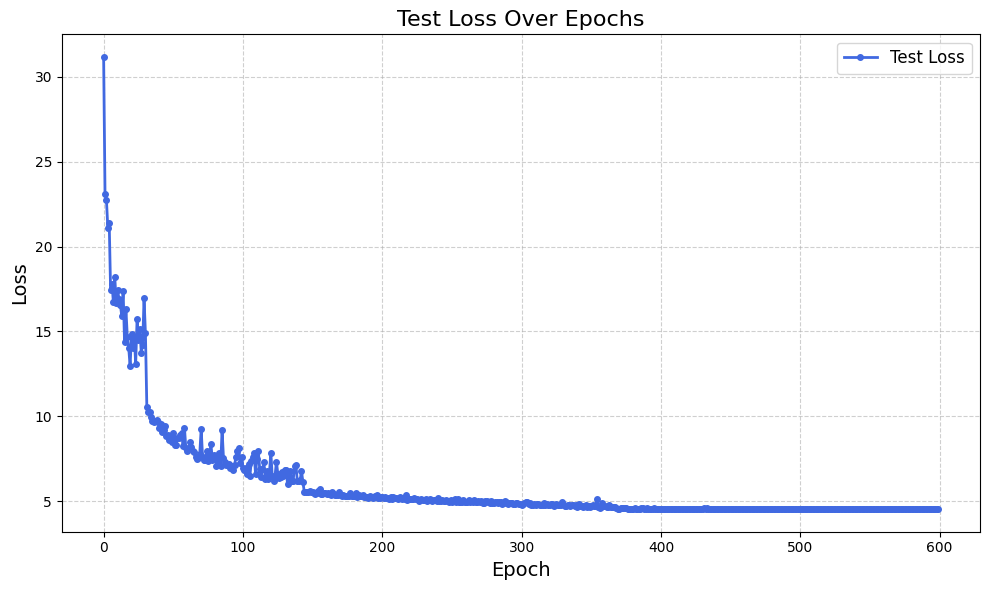

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='royalblue', linewidth=2, marker='o', markersize=4)

plt.title("Test Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()